# Neural Networks with Pure Python

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt (MIT license)

Lecture 1

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- implement the forward-pass (evaluation) of a deep, fully connected neural network in a few lines of python
- do that efficiently using batches
- illustrate the results for randomly initialized neural networks

### Imports: only numpy and matplotlib

In [16]:
import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

## A very simple neural network (no hidden layer)

A network with N0 input neurons and N1 output neurons (no hidden layer)

$$y^{\rm out}_j = f(\sum_k w_{jk} y^{\rm in}_k + b_j)$$

where $w$ is the weight matrix, $b$ is the bias vector, and $f$ would be the activation function (e.g. the sigmoid here), which is applied independently for each $j$.

In [3]:
N0=3 # input layer size
N1=2 # output layer size

# initialize random weights: array dimensions N1xN0
w=np.random.uniform(low=-1,high=+1,size=(N1,N0))
# initialize random biases: N1 vector
b=np.random.uniform(low=-1,high=+1,size=N1)

In [4]:
# input values
y_in=np.array([0.2,0.4,-0.1])

In [5]:
# evaluate network by hand, in two steps
z=np.dot(w,y_in)+b # result: the vector of 'z' values, length N1
y_out=1/(1+np.exp(-z)) # the 'sigmoid' function (applied elementwise)

In [6]:
print("network input y_in:", y_in)
print("weights w:", w)
print("bias vector b:", b)
print("linear superposition z:", z)
print("network output y_out:", y_out)

network input y_in: [ 0.2  0.4 -0.1]
weights w: [[ 0.21387125 -0.91541166 -0.12958683]
 [-0.81944053  0.27444027 -0.01089518]]
bias vector b: [-0.5879878  -0.25439119]
linear superposition z: [-0.89841953 -0.30741367]
network output y_out: [0.28937539 0.42374616]


### Visualize network result

Still stay with the simple network, but define a function that evaluates the network, and visualize the  output for various inputs

In [7]:
# a function that applies the network
def apply_net(y_in):
    global w, b
    
    z=np.dot(w,y_in)+b    
    return(1/(1+np.exp(-z)))

In [8]:
N0=2 # input layer size
N1=1 # output layer size

w=np.random.uniform(low=-10,high=+10,size=(N1,N0)) # random weights: N1xN0
b=np.random.uniform(low=-1,high=+1,size=N1) # biases: N1 vector

In [13]:
apply_net([0.8,0.3]) # a simple test

array([0.34827246])

In [14]:
# Note: this is NOT the most efficient way to do this! (but simple)
# We will later learn to use array syntax efficiently

M=50 # will create picture of size MxM
y_out=np.zeros([M,M]) # array MxM, to hold the result

for j1 in range(M):
    for j2 in range(M):
        # out of these integer indices, generate
        # two values in the range -0.5...0.5
        # and then apply the network to those two
        # input values
        value0=float(j1)/M-0.5
        value1=float(j2)/M-0.5
        y_out[j1,j2]=apply_net([value0,value1])[0]

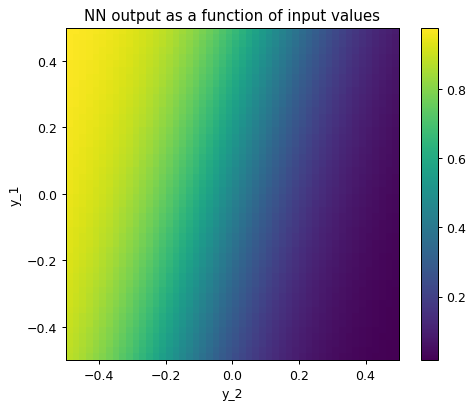

In [19]:
# display image
plt.imshow(y_out,origin='lower',extent=(-0.5,0.5,-0.5,0.5))
plt.colorbar()
plt.title("NN output as a function of input values")
plt.xlabel("y_2")
plt.ylabel("y_1")
plt.show()

### Now visualize a network with one hidden layer

The idea here is to have multiple weight matrices (for each pair of subsequent layers there is one weight matrix). The function that "applies a layer", i.e. goes from one layer to the next, is essentially the same as the function evaluating the simple network above. 

In [20]:
# a function that evaluates one layer based
# on the neuron values in the preceding layer
def apply_layer(y_in,w,b): 
    z=np.dot(w,y_in)+b
    return(1/(1+np.exp(-z)))

In [27]:
N0=2 # input layer size
N1=30 # hidden layer size
N2=1 # output layer size

# weights and biases
# from input layer to hidden layer:
w1=np.random.uniform(low=-10,high=+10,size=(N1,N0)) # random weights: N1xN0
b1=np.random.uniform(low=-1,high=+1,size=N1) # biases: N1 vector

# weights+biases from hidden layer to output layer:
w2=np.random.uniform(low=-10,high=+10,size=(N2,N1)) # random weights
b2=np.random.uniform(low=-1,high=+1,size=N2) # biases

In [23]:
# evaluate the network by subsequently
# evaluating the two steps (input to hidden and
# hidden to output)
def apply_net(y_in):
    global w1,b1,w2,b2
    
    y1=apply_layer(y_in,w1,b1)
    y2=apply_layer(y1,w2,b2)
    return(y2)

In [29]:
# Again, obtain values for a range of inputs
# Note: this is NOT the most efficient way to do this! (but simple)

M=50 # will create picture of size MxM
y_out=np.zeros([M,M]) # array MxM, to hold the result

for j1 in range(M):
    for j2 in range(M):
        value0=float(j1)/M-0.5
        value1=float(j2)/M-0.5
        y_out[j1,j2]=apply_net([value0,value1])[0]

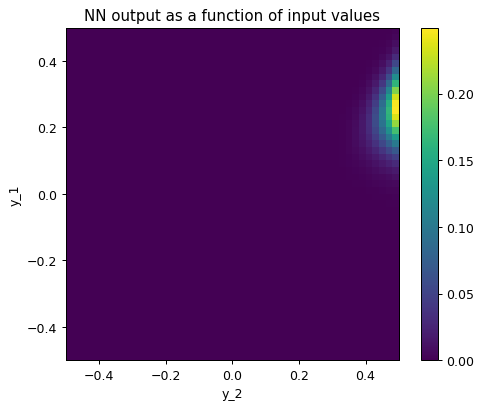

In [30]:
# display image
plt.imshow(y_out,origin='lower',extent=(-0.5,0.5,-0.5,0.5))
plt.colorbar()
plt.title("NN output as a function of input values")
plt.xlabel("y_2")
plt.ylabel("y_1")
plt.show()

Obviously, the shape of the output is already more 'complex' than that of a simple network without hidden layer! Let's go further in that direction...

### Applying a network to a 'batch' of samples (python trickery)

Goal: apply network to many samples in parallel (no 'for' loops!)

#### Small excursion: matrix-vector multiplication and python broadcasting of array dimensions

In [31]:
# See how the dot product works: 
# 'contracts' (sums over) the innermost index
W=np.zeros([7,8])
y=np.zeros([8,30])

# here '30' would stand for the number of samples
# in our envisaged network applications
np.shape(np.dot(W,y))

(7, 30)

In [32]:
# now try to add the bias vector entries,
# in the most naive way (beware!)
B=np.zeros(7)
result=np.dot(W,y)+B # will produce an error!

ValueError: operands could not be broadcast together with shapes (7,30) (7,) 

In [33]:
# But with a re-ordering of indices, this works!
# So, let's take the dimension of size 30 to be
# the very first one:
y=np.zeros([30,8])
W=np.zeros([8,7])
np.shape(np.dot(y,W))

(30, 7)

In [36]:
# and now try again adding the bias vector,
# again in a naive way
B=np.zeros(7)
result=np.dot(y,W)+B 
# will give the desired result, 
# because B is 'broadcast' to shape (30,7)
np.shape(result)

(30, 7)

#### Defining the functions that evaluate a layer and evaluate the network, with batch processing

Set up for batch processing, i.e. parallel evaluation of many input samples!

In [37]:
def apply_layer_new(y_in,w,b): # a function that applies a layer    
    z=np.dot(y_in,w)+b # note different order in matrix product!
    return(1/(1+np.exp(-z)))

In [38]:
def apply_net_new(y_in): # same as before, but with new layer function
    global w1,b1,w2,b2
    
    y1=apply_layer_new(y_in,w1,b1)
    y2=apply_layer_new(y1,w2,b2)
    return(y2)

In [52]:
N0=2 # input layer size
N1=5 # hidden layer size
N2=1 # output layer size

# from input layer to hidden layer:
w1=np.random.uniform(low=-10,high=+10,size=(N0,N1)) # NEW ORDER!! N0xN1
b1=np.random.uniform(low=-1,high=+1,size=N1) # biases: N1 vector

# from hidden layer to output layer:
w2=np.random.uniform(low=-10,high=+10,size=(N1,N2)) # NEW ORDER N1xN2
b2=np.random.uniform(low=-1,high=+1,size=N2) # biases

In [53]:
batchsize=10000
y=np.random.uniform(low=-1,high=1,size=(batchsize,2)) #2 is equal to N0 I guess [FB]

In [54]:
y_out=apply_net_new(y)

In [55]:
np.shape(y_out) 
# these were 10000 samples evaluated in parallel!!!

(10000, 1)

### Now visualize multi-layer net again, but more efficiently!

All the pixels in the image are samples, process all of them together!

In [64]:
M=50
# Generate a 'mesh grid', i.e. x,y values in an image
v0,v1=np.meshgrid(np.linspace(-0.5,0.5,M),np.linspace(-0.5,0.5,M))

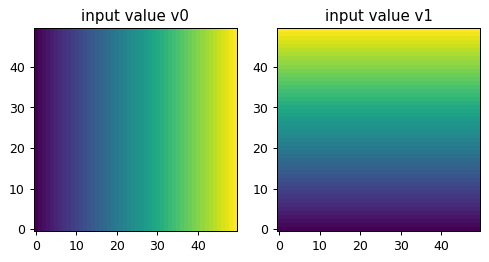

In [65]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(v0,origin='lower')
ax[0].set_title("input value v0")
ax[1].imshow(v1,origin='lower')
ax[1].set_title("input value v1")
plt.show()

In [66]:
v0flat=v0.flatten() # make 1D array out of 2D array
v1flat=v1.flatten() 
# that means: MxM matrix becomes M^2 vector
np.shape(v0flat)

(2500,)

In [68]:
batchsize=np.shape(v0flat)[0] # number of samples = number of pixels
y_in=np.zeros([batchsize,2])
y_in[:,0]=v0flat # fill first component (index 0)
y_in[:,1]=v1flat # fill second component

In [69]:
# apply net to all these samples simultaneously!
y_out=apply_net_new(y_in) 

In [70]:
np.shape(y_out) # this is not a vector but a funny matrix batchsize x 1

(2500, 1)

In [71]:
# turn this back into a 2D matrix (image)
y_2D=np.reshape(y_out[:,0],[M,M]) 

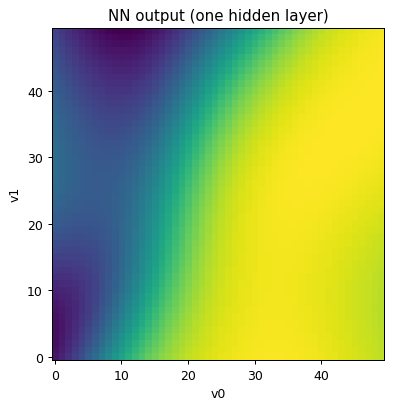

In [72]:
plt.imshow(y_2D,origin='lower')
plt.title("NN output (one hidden layer)")
plt.xlabel("v0")
plt.ylabel("v1")
plt.show()

### For fun: a network with MANY hidden layers

In [73]:
Nlayers=20 # not counting the input layer & the output layer
LayerSize=100

Weights=np.random.uniform(low=-3,high=3,size=[Nlayers,LayerSize,LayerSize])
Biases=np.random.uniform(low=-1,high=1,size=[Nlayers,LayerSize])

# for the first hidden layer (coming in from the input layer)
WeightsFirst=np.random.uniform(low=-1,high=1,size=[2,LayerSize])
BiasesFirst=np.random.uniform(low=-1,high=1,size=LayerSize)

# for the final layer (i.e. the output neuron)
WeightsFinal=np.random.uniform(low=-1,high=1,size=[LayerSize,1])
BiasesFinal=np.random.uniform(low=-1,high=1,size=1)

In [74]:
def apply_multi_net(y_in):
    global Weights, Biases, WeightsFinal, BiasesFinal, Nlayers
    
    y=apply_layer_new(y_in,WeightsFirst,BiasesFirst)    
    for j in range(Nlayers):
        y=apply_layer_new(y,Weights[j,:,:],Biases[j,:])
    output=apply_layer_new(y,WeightsFinal,BiasesFinal)
    return(output)

In [75]:
# Generate a 'mesh grid', i.e. x,y values in an image
M=40
v0,v1=np.meshgrid(np.linspace(-0.5,0.5,M),np.linspace(-0.5,0.5,M))
batchsize=M**2 # number of samples = number of pixels = M^2
y_in=np.zeros([batchsize,2])
y_in[:,0]=v0.flatten() # fill first component (index 0)
y_in[:,1]=v1.flatten() # fill second component

In [76]:
# use the MxM input grid that we generated above 
y_out=apply_multi_net(y_in) # apply net to all these samples!

In [77]:
y_2D=np.reshape(y_out[:,0],[M,M]) # back to 2D image

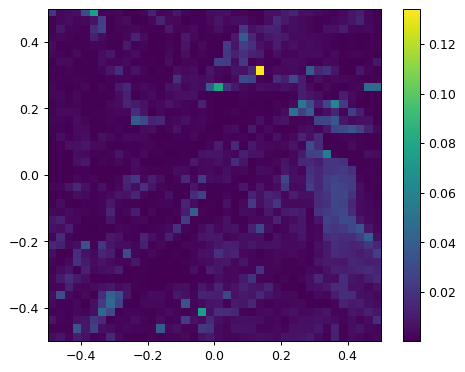

In [78]:
plt.imshow(y_2D,origin='lower',extent=[-0.5,0.5,-0.5,0.5],interpolation='nearest')
plt.colorbar()
plt.show()

Now do the same, but high-resolution (400x400 picture)

In [79]:
M=400
# Generate a 'mesh grid', i.e. x,y values in an image
v0,v1=np.meshgrid(np.linspace(-0.5,0.5,M),np.linspace(-0.5,0.5,M))
batchsize=M**2 # number of samples = number of pixels = M^2
y_in=np.zeros([batchsize,2])
y_in[:,0]=v0.flatten() # fill first component (index 0)
y_in[:,1]=v1.flatten() # fill second component

The next function takes a few seconds:

In [80]:
# use the MxM input grid that we generated above 
y_out=apply_multi_net(y_in) # apply net to all these samples!

In [81]:
y_2D=np.reshape(y_out[:,0],[M,M]) # back to 2D image

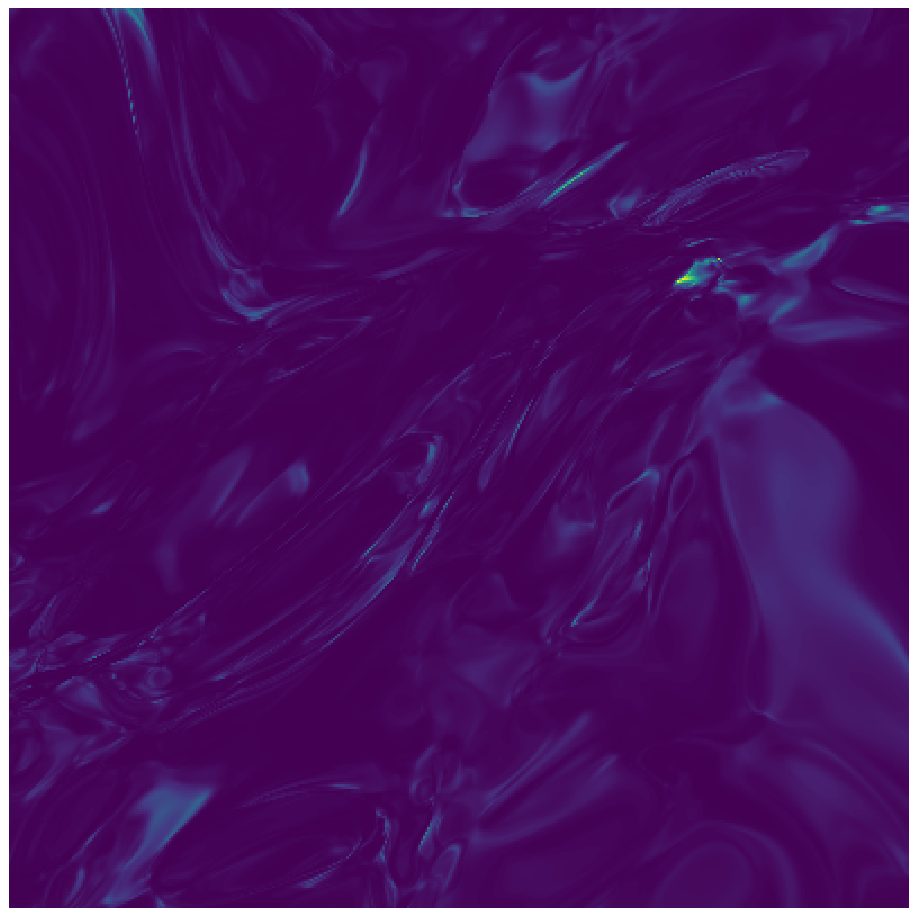

In [82]:
plt.figure(figsize=[10,10])
plt.axes([0,0,1,1]) # fill all of the picture with the image
plt.imshow(y_2D,origin='lower',extent=[-0.5,0.5,-0.5,0.5],interpolation='nearest')
plt.axis('off') # no axes
plt.show()